In [1]:
import xarray as xr
import os
import glob
import geopandas as gpd
import pandas as pd
import numpy as np
from scipy.stats import linregress
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from matplotlib.ticker import MaxNLocator

In [17]:
'''
lat = data['XLAT'].isel(west_east=0).values
lon = data['XLONG'].isel(south_north=0).values
'''

"\nlat = data['XLAT'].isel(west_east=0).values\nlon = data['XLONG'].isel(south_north=0).values\n"

In [2]:
path='/center1/DYNDOWN/phutton5/ROS/All_of_AK/All_of_AK_netcdf_files'

rain_ros_avg = xr.open_dataset(path+'/linear_trend_rain_ros_avg_1950_2022.nc')
rain_ros_sum = xr.open_dataset(path+'/linear_trend_rain_ros_sum_1950_2022.nc')
ros_days_count = xr.open_dataset(path+'/linear_trend_ros_days_count_1950_2022.nc')
ros_tally = xr.open_dataset(path+'/linear_trend_ros_tally_1950_2022.nc')
T2_avg = xr.open_dataset(path+'/linear_trend_T2_avg_1950_2022.nc')
T2_ros_avg = xr.open_dataset(path+'/linear_trend_T2_ros_avg_1950_2022.nc')  
swe_avg=xr.open_dataset(path+'/linear_trend_swe_avg_1950_2022.nc') 
seasonal_ros_hourly = xr.open_dataset(path+'/linear_seasonal_trend_ros_hourly_1950_2022.nc')


In [ ]:
'''
path='/center1/DYNDOWN/phutton5/ROS/All_of_AK/All_of_AK_netcdf_files'

rain_ros_avg = xr.open_dataset(path+'/theilsen_trend_rain_ros_avg_1950_2022.nc')
rain_ros_sum = xr.open_dataset(path+'/theilsen_trend_rain_ros_sum_1950_2022.nc')
ros_days_count = xr.open_dataset(path+'/theilsen_trend_ros_days_count_1950_2022.nc')
ros_tally = xr.open_dataset(path+'/theilsen_trend_ros_1950-2022.nc')
T2_avg = xr.open_dataset(path+'/theilsen_trend_T2_avg_1950_2022.nc')
T2_ros_avg = xr.open_dataset(path+'/theilsen_trend_T2_ros_avg_1950_2022.nc')
swe_avg=xr.open_dataset(path+'/theilsen_trend_swe_avg_1950_2022.nc')  
#seasonal_ros_hourly = xr.open_dataset(path+'/linear_seasonal_trend_ros_hourly_1950_2022.nc')
'''

In [3]:
shapefile_path = "/center1/DYNDOWN/phutton5/ROS/boundaries/Alaska_Borough_and_Census_Area_Boundaries.shp"
borough_boundaries = gpd.read_file(shapefile_path)
borough_boundaries = borough_boundaries.set_crs(epsg=3338)
borough_boundaries = borough_boundaries.to_crs(epsg=4326)
FNSB_boundary = borough_boundaries[borough_boundaries['CommunityN'] == 'Fairbanks North Star Borough']
FNSB_geom = FNSB_boundary.geometry.iloc[0] 
FNSB_coords = []
FNSB_coords.extend(list(FNSB_geom.exterior.coords))
FNSB_coords = np.array(FNSB_coords)  
FNSB_coords = pd.DataFrame({
    "lon": FNSB_coords[:, 0],
    "lat": FNSB_coords[:, 1]})

Fairbanks_lat=(64.84)
Fairbanks_lon=(-147.72)
lat=rain_ros_avg['XLAT']
lon=rain_ros_avg['XLONG']

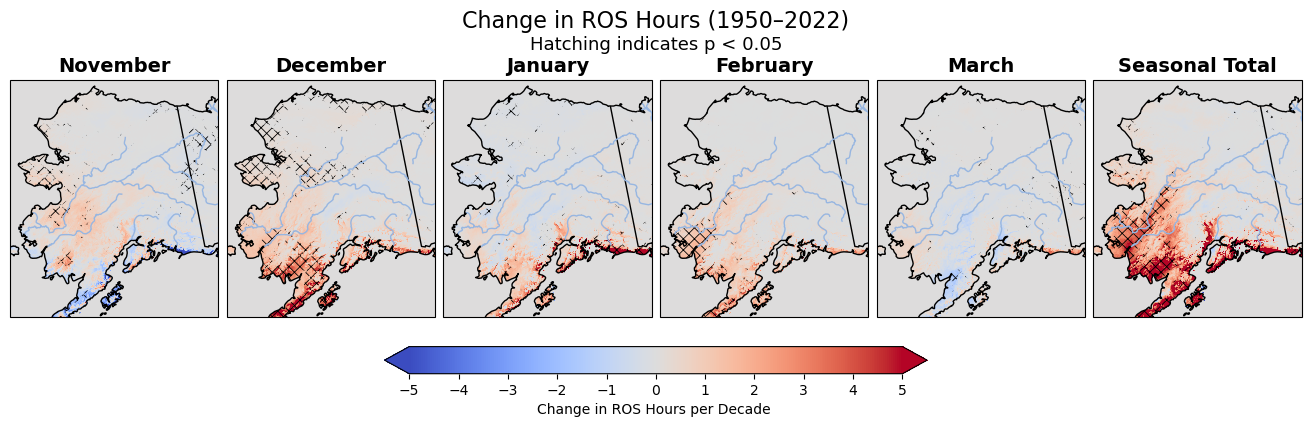

In [7]:
AK_ALBERS_SUBPLOT_KW = {
    'projection': ccrs.AlbersEqualArea(
        central_longitude=-154,
        central_latitude=50,
        standard_parallels=(55, 65))}

fig, axs = plt.subplots(nrows=1, ncols=6, figsize=(13, 4.5), subplot_kw=AK_ALBERS_SUBPLOT_KW, constrained_layout=True)

vmin, vmax = -5, 5
datasets = [
    (ros_tally['slope'].sel(month=11)*10,ros_tally['pval'].sel(month=11), "November"),
    (ros_tally['slope'].sel(month=12)*10,ros_tally['pval'].sel(month=12), "December"),
    (ros_tally['slope'].sel(month=1)*10,ros_tally['pval'].sel(month=1), "January"),
    (ros_tally['slope'].sel(month=2)*10,ros_tally['pval'].sel(month=2), "February"),
    (ros_tally['slope'].sel(month=3)*10,ros_tally['pval'].sel(month=3), "March"),
    (seasonal['slope']*10, seasonal_ros_hourly['pval'], "Seasonal Total")
]

for ax, (data, pvals, title) in zip(axs, datasets):
    pcm = ax.pcolormesh(
        lon, lat, data,
        cmap=cmap,
        vmin=vmin, vmax=vmax,  
        shading='auto',
        transform=ccrs.PlateCarree())
    ax.set_title(title, fontsize=14, fontweight="bold")

    sig = pvals < 0.05
    ax.contourf(lon, lat, sig, levels=[0.5, 1.5],colors='none', hatches=['XXX'],transform=ccrs.PlateCarree())
    
    ax.add_feature(cfeature.BORDERS, zorder=8)
    ax.add_feature(cfeature.COASTLINE, zorder=8)
    ax.add_feature(cfeature.RIVERS, zorder=8)
    ax.set_extent([-165.3, -141, 55.8, 71.38], crs=ccrs.PlateCarree())
    ax.set_aspect('equal')


cbar = fig.colorbar( pcm, ax=axs, orientation='horizontal', fraction=0.08, pad=0.08, extend='both')
fig.suptitle("Change in ROS Hours (1950–2022)",fontsize=16, y=0.92)
fig.text(0.5, 0.83, "Hatching indicates p < 0.05",ha='center',fontsize=13)
cbar.set_label('Change in ROS Hours per Decade ')
cbar.set_ticks(np.arange(-5, 6, 1))  
fig.patch.set_alpha(0.0)
plt.show()

rain_ros_avg,rain_ros_sum,T2_avg,T2_ros_avg

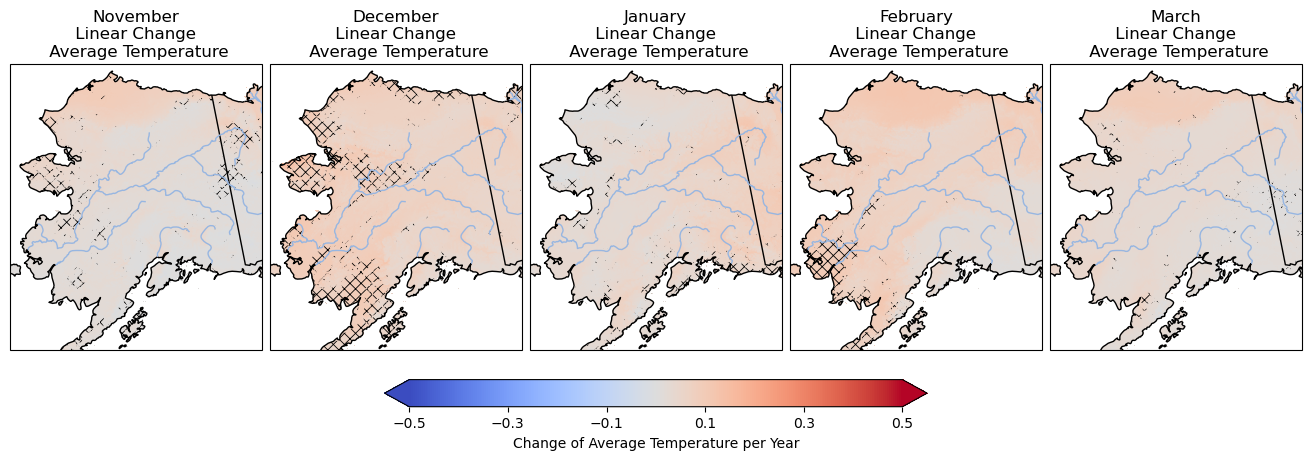

In [8]:
AK_ALBERS_SUBPLOT_KW = {
    'projection': ccrs.AlbersEqualArea(
        central_longitude=-154,
        central_latitude=50,
        standard_parallels=(55, 65))}
fig, axs = plt.subplots(
    nrows=1, ncols=5,
    figsize=(13, 4.5),
    subplot_kw=AK_ALBERS_SUBPLOT_KW,
    constrained_layout=True)

vmin, vmax = -0.5, 0.5
cmap = 'coolwarm'

datasets = [
    (T2_avg['slope'].sel(month=11), "November\n Linear Change \n Average Temperature"),
    (T2_avg['slope'].sel(month=12), "December\n Linear Change \n Average Temperature"),
    (T2_avg['slope'].sel(month=1), "January\n Linear Change \n Average Temperature"),
    (T2_avg['slope'].sel(month=2), "February\n Linear Change \n Average Temperature"),
    (T2_avg['slope'].sel(month=3), "March\n Linear Change \n Average Temperature"),
    #(ds_trend['slope'].sel(np.sum(month)),"Total Linear Change Winter ROS")]
]
for ax, (data, title) in zip(axs, datasets):
    pcm = ax.pcolormesh(
        lon, lat, data,
        cmap=cmap,
        vmin=vmin, vmax=vmax,
        shading='auto',
        transform=ccrs.PlateCarree())
    pvals = ros_tally['pval'].sel(month=data.month)
    sig = pvals < 0.05

    ax.contourf(
        lon, lat,
        sig,
        levels=[0.5, 1.5],
        colors='none',
        hatches=['XXX'],
        transform=ccrs.PlateCarree()
    )
    ax.set_title(title)

    ax.add_feature(cfeature.BORDERS, zorder=8)
    ax.add_feature(cfeature.COASTLINE, zorder=8)
    ax.add_feature(cfeature.RIVERS, zorder=8)
    ax.set_extent([-165.3, -141, 55.8, 71.38], crs=ccrs.PlateCarree())
    ax.set_aspect('equal')

cbar = fig.colorbar(
    pcm,
    ax=axs,
    orientation='horizontal',
    fraction=0.08,
    pad=0.08,
    extend='both'
)

cbar.set_label('Change of Average Temperature per Year')
cbar.set_ticks(np.arange(-0.5, 0.51, 0.1)[::2])
fig.patch.set_alpha(0.0)
plt.show()

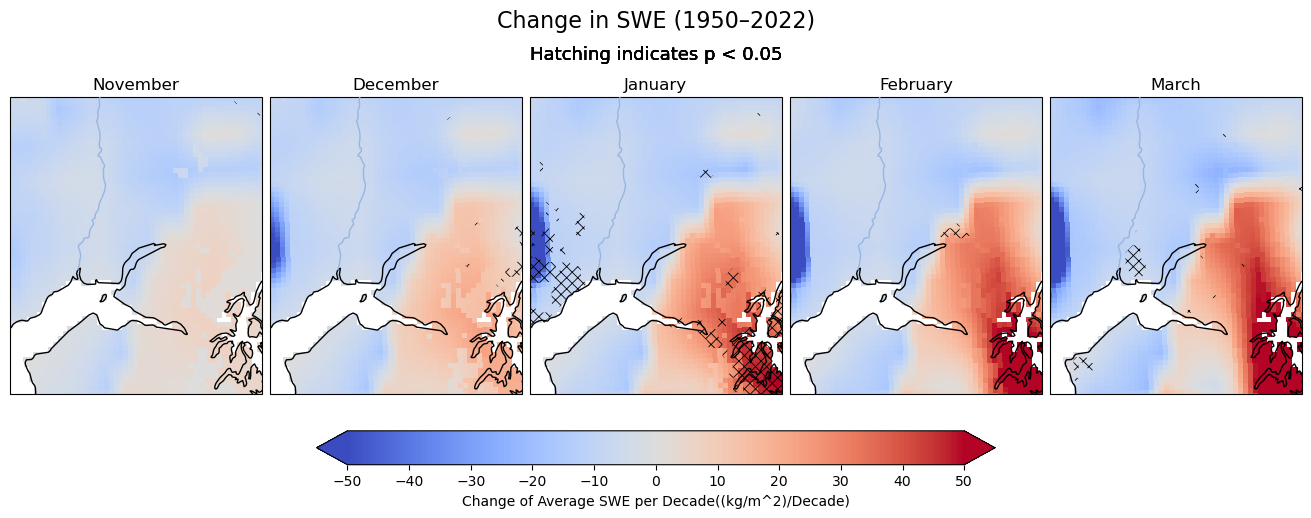

In [9]:
AK_ALBERS_SUBPLOT_KW = {
    'projection': ccrs.AlbersEqualArea(
        central_longitude=-154,
        central_latitude=50,
        standard_parallels=(55, 65))}
fig, axs = plt.subplots(
    nrows=1, ncols=5,
    figsize=(13, 5.5),
    subplot_kw=AK_ALBERS_SUBPLOT_KW,
    constrained_layout=True)

vmin, vmax = -50,50
cmap = 'coolwarm'

datasets = [
    (swe_avg['slope'].sel(month=11)*10, "November"),
    (swe_avg['slope'].sel(month=12)*10, "December"),
    (swe_avg['slope'].sel(month=1)*10, "January"),
    (swe_avg['slope'].sel(month=2)*10, "February"),
    (swe_avg['slope'].sel(month=3)*10, "March"),
    #(ds_trend['slope'].sel(np.sum(month)),"Total Linear Change Winter ROS")]
]
for ax, (data, title) in zip(axs, datasets):
    pcm = ax.pcolormesh(
        lon, lat, data,
        cmap=cmap,
        vmin=vmin, vmax=vmax,
        shading='auto',
        transform=ccrs.PlateCarree())
#    ax.set_extent([-151.5, -148, 60.5, 62.5], crs=ccrs.PlateCarree()) 
    pvals = ros_tally['pval'].sel(month=data.month)
    sig = pvals < 0.05

    ax.contourf(
        lon, lat,
        sig,
        levels=[0.5, 1.5],
        colors='none',
        hatches=['XXX'],
        transform=ccrs.PlateCarree()
    )
    
    ax.set_title(title)
    fig.text(0.5, 0.83, "Hatching indicates p < 0.05",ha='center',fontsize=13)

    ax.add_feature(cfeature.BORDERS, zorder=8)
    ax.add_feature(cfeature.COASTLINE, zorder=8)
    ax.add_feature(cfeature.RIVERS, zorder=8)
    #ax.set_extent([-165.3, -141, 55.8, 71.38], crs=ccrs.PlateCarree())
    ax.set_extent([-151.5, -148, 60.5, 62.5], crs=ccrs.PlateCarree()) 
    ax.set_aspect('equal')

cbar = fig.colorbar(
    pcm,
    ax=axs,
    orientation='horizontal',
    fraction=0.08,
    pad=0.08,
    extend='both'
)
fig.suptitle("Change in SWE (1950–2022)",fontsize=16, y=0.92)
cbar.set_label('Change of Average SWE per Decade((kg/m^2)/Decade)')
cbar.set_ticks(np.arange(-50, 55, 5)[::2])

fig.patch.set_alpha(0.0)
plt.show()

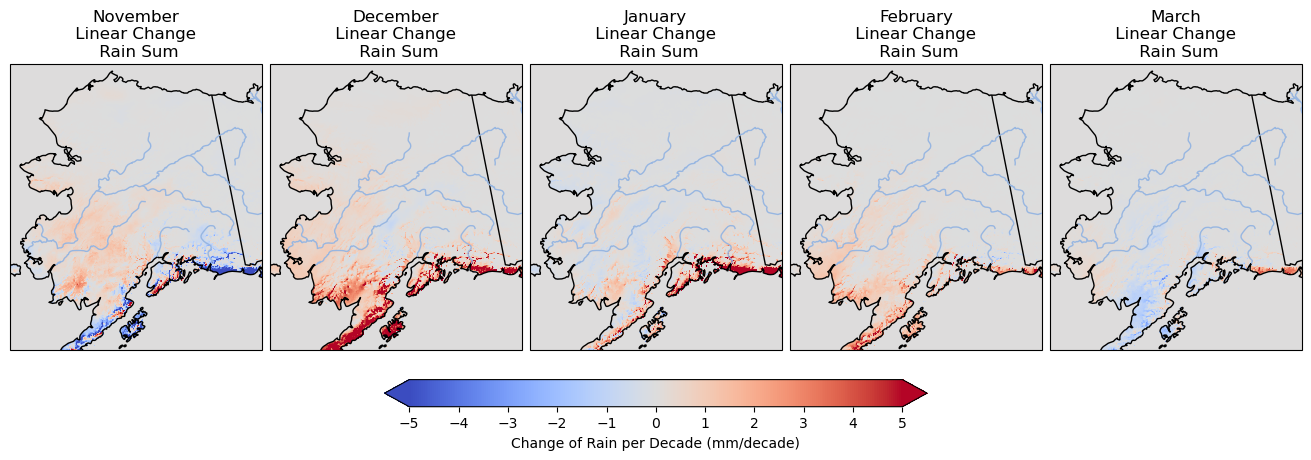

In [10]:

AK_ALBERS_SUBPLOT_KW = {
    'projection': ccrs.AlbersEqualArea(
        central_longitude=-154,
        central_latitude=50,
        standard_parallels=(55, 65))}
fig, axs = plt.subplots(
    nrows=1, ncols=5,
    figsize=(13, 4.5),
    subplot_kw=AK_ALBERS_SUBPLOT_KW,
    constrained_layout=True)

vmin, vmax = -5,5
cmap = 'coolwarm'

datasets = [
    (rain_ros_sum['slope'].sel(month=11)*10, "November\n Linear Change \n Rain Sum"),
    (rain_ros_sum['slope'].sel(month=12)*10, "December\n Linear Change \n Rain Sum"),
    (rain_ros_sum['slope'].sel(month=1)*10, "January\n Linear Change \n Rain Sum"),
    (rain_ros_sum['slope'].sel(month=2)*10, "February\n Linear Change \n Rain Sum"),
    (rain_ros_sum['slope'].sel(month=3)*10, "March\n Linear Change \n Rain Sum"),
    #(rain_ros_sum['slope'].sel(np.sum(month)),"Total Linear Change Winter ROS")]
]
for ax, (data, title) in zip(axs, datasets):
    pcm = ax.pcolormesh(
        lon, lat, data,
        cmap=cmap,
        vmin=vmin, vmax=vmax,
        shading='auto',
        transform=ccrs.PlateCarree())
    #pvals = ros_tally['pval'].sel(month=data.month)
    #sig = pvals < 0.05
    '''
    ax.contourf(
        lon, lat,
        sig,
        levels=[0.5, 1.5],
        colors='none',
        hatches=['XXX'],
        transform=ccrs.PlateCarree()
    )
    '''
    ax.set_title(title)

    ax.add_feature(cfeature.BORDERS, zorder=8)
    ax.add_feature(cfeature.COASTLINE, zorder=8)
    ax.add_feature(cfeature.RIVERS, zorder=8)
    ax.set_extent([-165.3, -141, 55.8, 71.38], crs=ccrs.PlateCarree())
    ax.set_aspect('equal')

cbar = fig.colorbar(
    pcm,
    ax=axs,
    orientation='horizontal',
    fraction=0.08,
    pad=0.08,
    extend='both'
)

cbar.set_label('Change of Rain per Decade (mm/decade)')
cbar.set_ticks(np.arange(-5, 5.5, 0.5)[::2])
fig.patch.set_alpha(0.0)
plt.show()

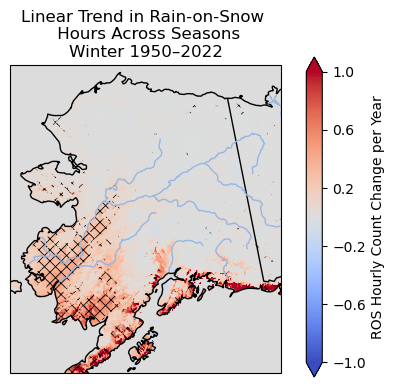

In [11]:
AK_ALBERS_SUBPLOT_KW = {
    'projection': ccrs.AlbersEqualArea(
        central_longitude=-154,
        central_latitude=50,
        standard_parallels=(55, 65))}

fig, ax = plt.subplots(subplot_kw=AK_ALBERS_SUBPLOT_KW, figsize=(10, 4))

# Make background transparent
fig.patch.set_alpha(0)
ax.set_facecolor('none')

pcm = ax.pcolormesh(
    lon, lat, np.sum(ros_tally['slope'], axis=0),
    cmap='coolwarm',
    vmin=-1, vmax=1,
    shading='auto',
    transform=ccrs.PlateCarree()
)
pvals = seasonal_ros_hourly['pval']
sig = pvals < 0.05

ax.contourf(
        lon, lat,
        sig,
        levels=[0.5, 1.5],
        colors='none',
        hatches=['XXX'],
        transform=ccrs.PlateCarree()
    )
cbar = fig.colorbar(pcm, ax=ax, extend='both',label='ROS Hourly Count Change per Year')
cbar.set_ticks(np.arange(-1, 1.2, .2)[::2])
cbar.ax.set_position([0.77, 0.1, 0.02, 0.8])

ax.add_feature(cfeature.BORDERS, zorder=9)
ax.add_feature(cfeature.COASTLINE, zorder=9)
ax.add_feature(cfeature.RIVERS, zorder=9)

ax.set_title(
    "Linear Trend in Rain-on-Snow \n Hours Across Seasons\n"
    "Winter 1950–2022"
)

ax.set_extent([-165.3, -141, 55.8, 71.38], crs=ccrs.PlateCarree())
ax.set_aspect('equal')
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.show()


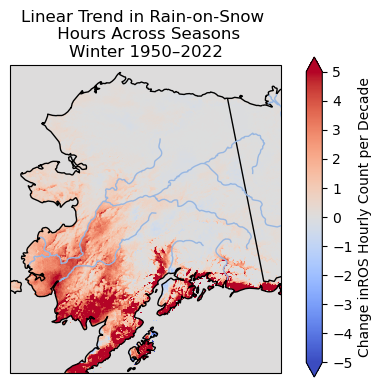

In [12]:
AK_ALBERS_SUBPLOT_KW = {
    'projection': ccrs.AlbersEqualArea(
        central_longitude=-154,
        central_latitude=50,
        standard_parallels=(55, 65))}

fig, ax = plt.subplots(subplot_kw=AK_ALBERS_SUBPLOT_KW, figsize=(10, 4))

# Make background transparent
fig.patch.set_alpha(0)
ax.set_facecolor('none')

pcm = ax.pcolormesh(
    lon, lat, np.sum(ros_tally['slope'], axis=0)*10,
    cmap='coolwarm',
    vmin=-5, vmax=5,
    shading='auto',
    transform=ccrs.PlateCarree()
)


cbar = fig.colorbar(pcm, ax=ax, extend='both',label='Change inROS Hourly Count per Decade')
cbar.set_ticks(np.arange(-5, 5.5, 0.5)[::2])
cbar.ax.set_position([0.77, 0.1, 0.02, 0.8])

ax.add_feature(cfeature.BORDERS, zorder=9)
ax.add_feature(cfeature.COASTLINE, zorder=9)
ax.add_feature(cfeature.RIVERS, zorder=9)

ax.set_title(
    "Linear Trend in Rain-on-Snow \n Hours Across Seasons\n"
    "Winter 1950–2022")

ax.set_extent([-165.3, -141, 55.8, 71.38], crs=ccrs.PlateCarree())
ax.set_aspect('equal')
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.show()

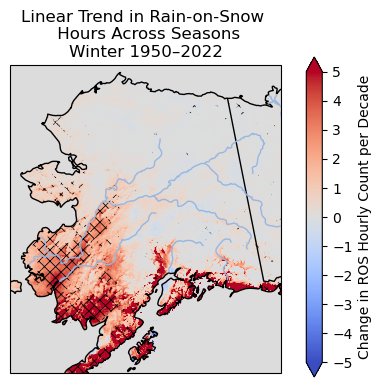

In [13]:
AK_ALBERS_SUBPLOT_KW = {
    'projection': ccrs.AlbersEqualArea(
        central_longitude=-154,
        central_latitude=50,
        standard_parallels=(55, 65))}

fig, ax = plt.subplots(subplot_kw=AK_ALBERS_SUBPLOT_KW, figsize=(10, 4))

# Make background transparent
fig.patch.set_alpha(0)
ax.set_facecolor('none')

pcm = ax.pcolormesh(
    lon, lat, seasonal_ros_hourly['slope']*10,
    cmap='coolwarm',
    vmin=-5, vmax=5,
    shading='auto',
    transform=ccrs.PlateCarree()
)
pvals = seasonal_ros_hourly['pval']
sig = pvals < 0.05

ax.contourf(
        lon, lat,
        sig,
        levels=[0.5, 1.5],
        colors='none',
        hatches=['XXX'],
        transform=ccrs.PlateCarree()
    )

cbar = fig.colorbar(pcm, ax=ax, extend='both',label='Change in ROS Hourly Count per Decade')
cbar.set_ticks(np.arange(-5, 5.5, 0.5)[::2])
cbar.ax.set_position([0.77, 0.1, 0.02, 0.8])

ax.add_feature(cfeature.BORDERS, zorder=9)
ax.add_feature(cfeature.COASTLINE, zorder=9)
ax.add_feature(cfeature.RIVERS, zorder=9)

ax.set_title(
    "Linear Trend in Rain-on-Snow \n Hours Across Seasons\n"
    "Winter 1950–2022"
)

ax.set_extent([-165.3, -141, 55.8, 71.38], crs=ccrs.PlateCarree())
ax.set_aspect('equal')
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.show()

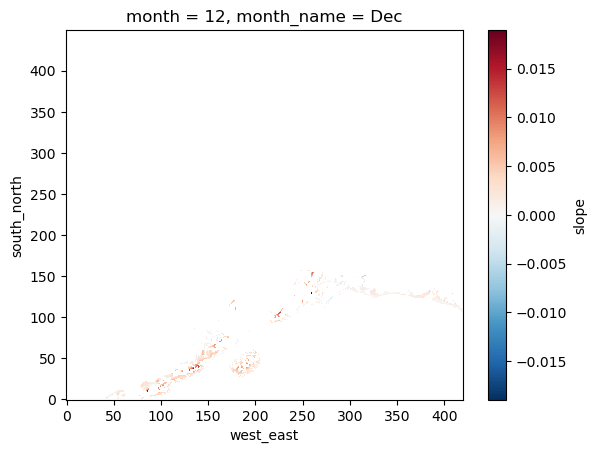

In [14]:
#np.sum(rain_ros_avg['slope'],axis=0).plot()
rain_ros_avg['slope'].sel(month=12).plot()
#average hourly rainfall 